In [1]:
import string
import random
from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from ipywidgets import interactive, HBox, VBox
from img_processing import preprocess_img, DITHER_MODES
from ascii_art_non_mono_utils import *
from ascii_art_non_mono_algorithms import *
from skimage import metrics

In [2]:
font_path = "fonts/OpenSans-Regular.ttf"
size = 16
fnt = ImageFont.truetype(font_path, size)

In [3]:
orig_img = Image.open("imgs/irad_grad.bmp").convert("L")
#orig_img = ImageOps.invert(orig_img)

print(orig_img.size)

(512, 512)


In [4]:
def i_preprocess_img(scale_factor, contrast, brightness, quantize_colors, eq, dither):
    proc_img = preprocess_img(orig_img, 0.3, 1.1, 0.9, 0.2, 128, DITHER_MODES.NONE)
    plt.imshow(proc_img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.figure(figsize=(9, 3))
    plt.xticks([x for x in range(0, len(proc_img.histogram()), 25)])
    plt.bar([x for x in range(0, len(proc_img.histogram()))], proc_img.histogram())
    plt.grid()
    plt.show()

    return proc_img

interactive_preprocess = interactive(i_preprocess_img,
            scale_factor=(0.01, 1, 0.01),
            contrast=(0, 2, 0.01),
            brightness=(0, 2, 0.01),
            eq=(0, 1, 0.01),
            quantize_colors=(1, 256, 1),
            dither=DITHER_MODES)

controls = VBox(interactive_preprocess.children[:-1])
#display(HBox((controls, interactive_preprocess.children[-1])))

In [5]:
proc_img = interactive_preprocess.result

In [6]:
palette = list(filter(lambda a: a.isprintable(), string.printable))
print(len(palette))
print(palette)

95
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']


In [7]:
# lrs = lazy_random_search(proc_img, palette, fnt)

# for i in range(0, 4001):
#     text = next(lrs)
#     if i % 1000 == 0:
#         print(evaluate_text_arr(text, proc_img, fnt))

# bg_img, draw = new_img_draw(proc_img.size)
# draw_text_arr(draw, text, fnt)
# ImageChops.add(proc_img, bg_img)

_||Q@Q@@@QQU-,
_@@@@@@@@@@ 
_M@MW@@@@%%j
 M@WWMWN@@%{
 MMMWMMMMW@'
 TMMMMWW%W@? 
 `==<<WMMW<<<<`' 

0.01223241943515032


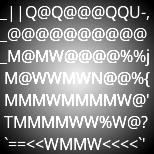

In [8]:
text = greedy_algorithm(proc_img, palette, fnt)

print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, fnt)
print(evaluate_text_arr(text, proc_img, fnt))
ImageChops.add(proc_img, bg_img)

0.006917213673704074
0.010355582689848047
0.010509358138746962
0.010935187932795522
_ (}FHgQL@Lggq{'<,,_ax`zca\b{ v.YBjy{ G
_0pjg2@gJVJgg@{AK,{;2tiRjA(BzP.5\/SVGvH
-kBNE61p@jJ[MM)>?-Oh>jyNgFfM_?3$j0e:64i
_N@EMnR(Rh@hI6U;#z@9z?jL,|#k'+=`@-D}*\H
-iJxfK{NA#f4QN[1@l! |T d!Ht*1/s2BMM?uj@
 7MMWMN>/fM7%'/_=Y\=A*FWEXiXa*MX~'4m}x*
==T1M%^WY'#<*<"` Y_&5W7+UC\eC6le@Lem1=I

0.011112901207606525


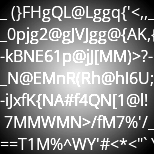

In [9]:
lhs = lazy_harmony_search(proc_img, palette, fnt, 5, 0.9, 0.3, len(palette)//2)

for i in range(4000):
    text = next(lhs)
    if i % 1000 == 0:
        print(evaluate_text_arr(text, proc_img, fnt))

text = next(lhs)
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, fnt)
print(evaluate_text_arr(text, proc_img, fnt))
ImageChops.add(proc_img, bg_img)